# Precision-Recall and Receiver Operating Characteristic Curves

In this notebook, we will learn about constructing and interpreting precision-recall (PR) and receiver operating characteristic (ROC) curves. These curves are typically used to judge the performances of probabilistic classifiers beyond the confusion matrix and other performance measures that are derived from the confusion matrix. Note that the confusion matrix primarily judges categorical decisions, while PR and ROC curves are assessing probabilistic decisions. If a classifier does indeed make only categorical decisions (e.g. True or False, 1 or 0, yes or no, etc..), it may be sufficient to stick with a confusion matrix (although it is possible to turn categorical decisions to probabilistic ones, see [isotonic regression](https://en.wikipedia.org/wiki/Isotonic_regression)). 

However, oftentimes, a classifier makes probabilistic predictions (e.g. 80% True and 20% False, 75% 1 and 25% 0, 33% yes and 67% no, etc...) and the tragedy of judging classifier performance starts by choosing an arbitrary threshold (typically, > 50%) to categorize the prediction. For example, if a probabilistic classifier predicts True at 80%, one might say that the prediction is categorically True (since 80% > 50%); if a prediction is True at 49%, one might say that the prediction is categorically False (since 49% < 50%). The 50% cut-off is arbitrary, and one may choose any cut-off or threshold to impact the confusion matrix. With PR and ROC curves, the idea is to vary the cut-off from $[0, 1]$ and measure the performance over all these thresholds. In fact, after varying the cut-off, one may use PR and ROC curves to choose an optimal threshold to balance for trade-offs between precision vs recall or true positive rate (TPR) vs false positive rate (FPR). 

To understand PR and ROC curves, first understand the confusion matrix. Assume that there are only 2 classes to predict; True and False. Then a 2 x 2 matrix may be created such that the rows represent the predictions and the columns represent the truth. 

```
+-------+------+-------+
|       | True | False |
+-------+------+-------+
| True  | tp   | fp    |
+-------+------+-------+
| False | fn   | tn    |
+-------+------+-------+
```

Each element in the confusion matrix stands for something.

* tp is the number of true positive (model predicts the observation as true when the observation is really true)
* fp is the number of false positive (model predicts the observation as true when the observation is really false)
* fn is the number of false negative (model predicts the observation as false when the observation is really true)
* tn is the number of true negative (model predicts the observation as false when the observation is really false)

From these simple counts, a wonderful list of performance measures may be created (refer to the [Wikipedia site](https://en.wikipedia.org/wiki/Confusion_matrix)). Here, we only focus on precision, recall, TPR and FPR, which are defined as follows.

* $\text{precision}=\frac{\text{TP}}{\text{TP} + \text{FP}}$
* $\text{recall}=\frac{\text{TP}}{\text{TP} + \text{FN}}$
* $\text{TPR}=\frac{\text{TP}}{\text{TP} + \text{FN}}$
* $\text{FPR}=\frac{\text{FP}}{\text{FP} + \text{TN}}$

Note that recall and TPR are the same thing and also referred to by many other names (e.g. sensitivity).

If a classifier is a probabilistic one, we may choose an arbitrary threshold, above which we will categorically say the prediction is True, to induce a confusion matrix and hence precision, recall, TPR and FPR. Changing the threshold will change the confusion matrix and hence, precision, recall, TPR and FPR (typically). We can `cheat` and choose one threshold to produce a set of desired precision, recall, TPR and FPR and report out that our classifier performs really well. However, we know better that we should look at these performance measures over all possible thresholds and report the aggregate (typically average) performance. The PR and ROC curves are visualizations of this operation, and the area under these curves (integrating over these curves) are the expected performance across all thresholds. 

The PR curve plots precision vs recall and we may observe the trade-off between the two; the ROC curve plots TPR vs FPR and we also observe the trade-off between the two. Note that precision, recall, TPR and FPR are scalar values that all lie in the range of $[0, 1]$. As such, the PR and ROC curves' domains in the x and y axis are also in the range $[0, 1]$. Meaning, the whole area is a square and a square with side length of 1 has an area of 1. This geometric understanding is important because when we draw the curve and integrate, the integration value will always be $[0, 1]$ where a lower value indicates `bad` performance and a higher value indicates `good` performance. The integration of the curve is often called the area under the curve (AUC), and the AUC for PR is denoted as AUC-PR and for ROC is AUC-ROC.

## Simulate data

Let's start out by simulating some data. We have 2 classes, 0 and 1, and we sample from 2 different multivariate gaussians.


* $\mu_0 = [1.5, 2.5, 3.3]$, $\Sigma_0 = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix}$
* $\mu_1 = [1.7, 2.9, 3.0]$, $\Sigma_1 = \begin{bmatrix} 1.0 & 0.5 & 0.2 \\ 0.5 & 1.0 & 2.0 \\ 0.2 & 2.0 & 1.0 \end{bmatrix}$

We purposefully make the means between the two models very similar to give the classifier problems deciding. We take 10,000 samples from each (total 20,000 samples) for training, `T`, and 25 samples from each (total 50 samples) for validation, `V`.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import namedtuple
from scipy.stats import multivariate_normal
import warnings

warnings.filterwarnings('ignore')
np.random.seed(37)

MVN = namedtuple('MVN', 'mean cov')
DATA = namedtuple('DATA', 'X, y')

mvn0 = MVN(np.array([1.5, 2.5, 3.3]), np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]))
mvn1 = MVN(np.array([1.7, 2.9, 3.0]), np.array([[1.0, 0.5, 0.2], [0.5, 1.0, 2.0], [0.2, 2.0, 1.0]]))

N = 10000
X0 = np.array([multivariate_normal.rvs(mvn0.mean, mvn0.cov) for _ in range(N)])
X1 = np.array([multivariate_normal.rvs(mvn1.mean, mvn1.cov) for _ in range(N)])
y0 = np.full((N, 1), 0, dtype=np.int32)
y1 = np.full((N, 1), 1, dtype=np.int32)

X = np.vstack([X0, X1])
y = np.vstack([y0, y1])

T = DATA(X, y)

N = 25
X0 = np.array([multivariate_normal.rvs(mvn0.mean, mvn0.cov) for _ in range(N)])
X1 = np.array([multivariate_normal.rvs(mvn1.mean, mvn1.cov) for _ in range(N)])
y0 = np.full((N, 1), 0, dtype=np.int32)
y1 = np.full((N, 1), 1, dtype=np.int32)

X = np.vstack([X0, X1])
y = np.vstack([y0, y1])

V = DATA(X, y)

## Learn a classifier

After we have our training `T` and validation `V` data, we plug in the data into a random forest classifier. We use the `predict_proba` function to retrieve the prediction probabilities of the validation example being 1 (or True). Below, `outcomes` is a list of tuples, where each tuple is a pair composed of the true label `y_t` and predicted label `y_p`.

In [2]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=37)
rf_model.fit(T.X, T.y)

y_pred = rf_model.predict_proba(V.X)[:,1]

outcomes = sorted([(y_t, y_p) for y_t, y_p in zip(V.y[:,0], y_pred)], 
                  key=lambda tup: (-tup[1], -tup[0]))

## Construct the precision-recall curve

Now with `y_t, y_p`, we create count tp, fp and fn and compute precision and recall. Note that `get_pr()` computes the precision and recall for one threshold `t`, and that `get_prs` returns a list of precisions, recalls, and thresholds. To make a precision-recall curve, we use the `step` function. We make two precision-recall curves; one where the precision and recall values are computed from Scikit and another one where these values are computed using our own code.  This side-by-side comparison is just to show that we know how to compute and graph these precision-recall curves ourselves. 

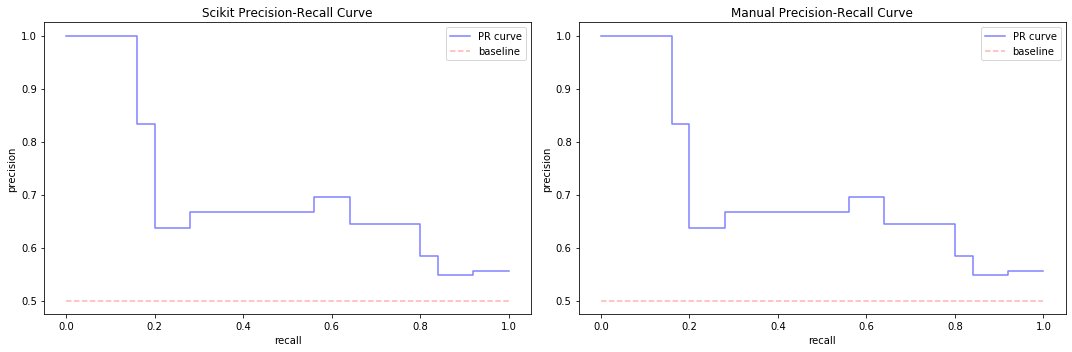

In [3]:
from sklearn.metrics import precision_recall_curve

def get_pr(outcomes, t):
    tp = 0
    fp = 0
    fn = 0

    for y_t, y_p in outcomes:
        clazz_t = int(y_t)
        clazz_p = 1 if y_p >= t else 0
        tp = tp + (1 if clazz_t == 1 and clazz_p == 1 else 0)
        fp = fp + (1 if clazz_t == 0 and clazz_p == 1 else 0)
        fn = fn + (1 if clazz_t == 1 and clazz_p == 0 else 0)

    pre = tp / (tp + fp)
    rec = tp / (tp + fn)
    return pre, rec

def get_prs(outcomes, thresholds=np.linspace(0.2, 1, 9)):
    pres = []
    recs = []
    thrs = []
    for t in thresholds:
        pre, rec = get_pr(outcomes, t)
        pres.append(pre)
        recs.append(rec)
        thrs.append(t)
    pres.append(1.0)
    recs.append(0.0)
    return np.array(pres), np.array(recs), np.array(thrs)

pre_m, rec_m, _ = get_prs(outcomes, thresholds=np.linspace(0.2, 1, 100))
pre_s, rec_s, _ = precision_recall_curve(V.y, y_pred)
baseline = np.sum(V.y) / len(V.y)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].step(rec_s, pre_s, color='b', alpha=0.5, where='post', label='PR curve')
ax[0].set_xlabel('recall')
ax[0].set_ylabel('precision')
ax[0].set_title('Scikit Precision-Recall Curve')
ax[0].plot((0, 1), (baseline, baseline), 'r--', alpha=0.3, label='baseline')
ax[0].legend()

ax[1].step(rec_m, pre_m, color='b', alpha=0.5, where='post', label='PR curve')
ax[1].set_xlabel('recall')
ax[1].set_ylabel('precision')
ax[1].set_title('Manual Precision-Recall Curve')
ax[1].plot((0, 1), (baseline, baseline), 'r--', alpha=0.3, label='baseline')
ax[1].legend()

plt.tight_layout()

## Integrate the precision-recall curve (using trapezoid method)

Now we integrate over these curves.

* `apr` is the average precision value computed from Scikit's API
* `apr_s` is the average precision value computed from our code (precision and recall from Scikit)
* `apr_m` is the average precision value computed from our code (precision and recall from our code)

Note how they are off? Our code uses trapezoid integration which is optimistic.

In [4]:
from sklearn.metrics import average_precision_score

def get_apr(pre, rec):
    x = np.flip(rec)
    y = np.flip(pre)
    return np.trapz(y, x)

apr = average_precision_score(V.y, y_pred)
apr_s = get_apr(pre_s, rec_s)
apr_m = get_apr(pre_m, rec_m)

print('apr = {:.5f}, apr_s = {:.5f}, apr_m = {:.5f}'.format(apr, apr_s, apr_m))

apr = 0.70137, apr_s = 0.71357, apr_m = 0.71357


## Integrate the precision-recall curve (using weighted average)

Here, we use the suggested conservative integration approach and now all average percision agree.

In [5]:
def get_apr(pre, rec):
    x = np.flip(rec)
    y = np.flip(pre)
    
    total = 0
    for i in range(len(x)):
        r_c = x[i]
        r_p = x[i if i - 1 < 0 else i - 1]
        p_i = y[i]
        a = (r_c - r_p) * p_i
        total = total + a
    return total

apr_s = get_apr(pre_s, rec_s)
apr_m = get_apr(pre_m, rec_m)

print('apr = {:.5f}, apr_s = {:.5f}, apr_m = {:.5f}'.format(apr, apr_s, apr_m))

apr = 0.70137, apr_s = 0.70137, apr_m = 0.70137


## Construct the receiver operating characterics (ROC) curve

We turn our attention to the ROC curve now. The algorithms for generating the data for PR and ROC curves are nearly identical and differ only in what we return. In PR, we return the precision and recall, but in ROC, we return TPR and FPR.

Note that here, we pass in thresholds in a descending order and there is a 2 prepended to the thresholds in $[0, 1]$. The 2 prepended to the thresholds is easy to explain; it's simply there to level off the curve (we actually did a similar thing when constructing the PR curve, although we manipulated the TPR and FPR instead of the thresholds). The descending order of the thresholds makes the FPR vector sort in an increasing sequence.

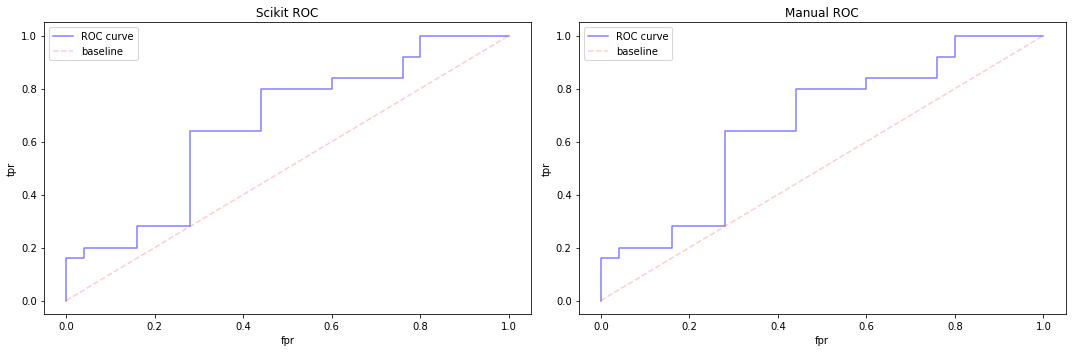

In [6]:
from sklearn.metrics import roc_curve

def get_fpr_tpr(outcomes, t):
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for y_t, y_p in outcomes:
        clazz_t = int(y_t)
        clazz_p = 1 if y_p >= t else 0
        tp = tp + (1 if clazz_t == 1 and clazz_p == 1 else 0)
        fp = fp + (1 if clazz_t == 0 and clazz_p == 1 else 0)
        fn = fn + (1 if clazz_t == 1 and clazz_p == 0 else 0)
        tn = tn + (1 if clazz_t == 0 and clazz_p == 0 else 0)

    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    return fpr, tpr

def get_all_fpr_tpr(outcomes, thresholds=np.flip(np.append(np.linspace(0, 1, 11), [2]))):
    fprs = []
    tprs = []
    thrs = []
    for t in thresholds:
        fpr, tpr = get_fpr_tpr(outcomes, t)
        fprs.append(fpr)
        tprs.append(tpr)
        thrs.append(t)
    return np.array(fprs), np.array(tprs), np.array(thrs)

fpr_m, tpr_m, t_m = get_all_fpr_tpr(outcomes, thresholds=np.flip(np.append(np.linspace(0, 1, 100), [2])))
fpr_s, tpr_s, t_s = roc_curve(V.y, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].step(fpr_s, tpr_s, color='b', alpha=0.5, where='post', label='ROC curve')
ax[0].set_xlabel('fpr')
ax[0].set_ylabel('tpr')
ax[0].set_title('Scikit ROC')
ax[0].plot((0, 1), (0, 1), 'r--', alpha=0.2, label='baseline')
ax[0].legend()

ax[1].step(fpr_m, tpr_m, color='b', alpha=0.5, where='post', label='ROC curve')
ax[1].set_xlabel('fpr')
ax[1].set_ylabel('tpr')
ax[1].set_title('Manual ROC')
ax[1].plot((0, 1), (0, 1), 'r--', alpha=0.2, label='baseline')
ax[1].legend()

plt.tight_layout()

## Integrate the ROC curve (using trapezoid method)

Here we use trapezoid integration over the ROC curves and observe that our manual approach agrees with Scikit's.

In [7]:
from sklearn.metrics import roc_auc_score

def get_auc(tpr, fpr):
    return np.trapz(tpr, fpr)

auc = roc_auc_score(V.y, y_pred)
auc_s = get_auc(tpr_s, fpr_s)
auc_m = get_auc(tpr_m, fpr_m)

print('auc = {:.5f}, auc_s = {:.5f}, auc_m = {:.5f}'.format(auc, auc_s, auc_m))

auc = 0.71200, auc_s = 0.71200, auc_m = 0.71200


## Interpretation of area under the curve (AUC)

The interpretations of AUC-PR and AUC-ROC are different. 

### AUC-ROC

The `baseline` curve in a ROC curve plot is the diagonal (bottom left to top right) line. The baseline diagonal splits the square into two equal halves and integrating over it will be 0.5. A ROC curve that aligns with this baseline curve is interpreted as doing no better than chance guessing. A ROC curve that `dominates` (is greater than) the baseline curve is interpreted as doing better than chance guessing. Finally, a ROC curve that is below the baseline curve does worse than chance guessing. 

An AUC-ROC equal to 0.5 indicates classification performance that is no better than chance guessing. A `perfect` ROC curve integrates to 1.0 and the classification performance is perfect (never wrong). If AUC-ROC is less than 0.5, then the classification performance is worse than guess/chance. It's interesting to note that in the case of an AUC-ROC that's very low, if we simply reverse the direction of decision, a really bad classifier can become a really good one. For example, if the area under the curve is 0.1, we may reverse our decision (e.g. turn True to False and False to True), and we should observe an AUC of 0.9! 

### AUC-PR

The `baseline` curve in a PR curve plot is a horizontal line (as opposed to the diagonal in the ROC cruve). Note that this PR baseline curve (horizontal line) does **NOT** split the area of the square (plot) into equal halves necessarily. The y-intercept of the PR baseline curve is determined by 

$b=\frac{P}{P + N}$,

where

* $P$ is the number of positive examples,
* $N$ is the number of negative examples, and
* $b$ denotes the baseline (percentage/proportion of positive examples).

Only when $P = N$ does the PR baseline curve split the plot area into equal halves. In the running classification example, note that $P = N$ as we had 25 positive and 25 negative examples. Also note that the integration over the PR baseline curve is always equal to $b$. 

AUC-PR is the expected probability of the model retrieving a relevant observation. When

* AUC-PR $ = b$, then the classifier does no better than randomly retrieving relevant examples,
* AUC-PR $ > b$, then the classifier does better than randomly retrieving relevant examples, and
* AUC-PR $ < b$, then the classifier does worse than randomly retrieving relevant examples.

### AUC-ROC and AUC-PR

Here are some closing thoughts on AUC-ROC and AUC-PR.

* Typically, both PR and ROC curves are plotted together, however, PR curves are very useful when there is `data imbalance` or `data skew` (very little examples of the positive class during training) or when you want to emphasize and characterize the classifier's performance for predicting the positive class. For example, if there are very few cases of a disease and you are building a classifier to predict for the presence of such disease in a patient, you might want to emphasize the PR curve over the ROC curve. 
* The PR curve does not care about TN (true negatives), and only focuses on the counts from the confusion matrix that deal with positive predictions (TP, FP, FN). On the other hand, the ROC curve considers all the counts (TP, FP, FN, TN) from the confusion matrix. 
* The AUC-ROC may be manipulated to appear better if one increases TN (puts a lot of negative examples into the the sample). 
* Note that the ROC baseline curve is diagonal and always the same across ROC plots but the PR baseline curve is horizontal and different across PR plots; this observation suggest that you may compare AUC-ROC for two different classifiers, each trained with different data, but you should not do so for AUC-PR (unless the baselines are the same). 
* Sometimes, one may wish to find an optimal cut-off/threshold from the PR or ROC curves. One typical way is to simply grab the threshold closest to the corner. For a PR curve, since it is decreasing from left to right, the threshold closest to the top right corner might be the optimal threshold. For a ROC curve, since it is increasing from left to right, the threshold closest to the top left corner might be the optimal threshold. Remember, thresholds selected off the PR and ROC curves do not maximize or optimize accuracy but the trade-off between precision-recall or TPR-FPR.
* There are faster ways of constructing the PR and ROC curves. Here, we construct the curves through defined thresholds and for $T$ thresholds, we have to pass over the data $T$ times. With $N$ data points, this means $TN$ operations. If we sort the predictions descendingly by their probabilities of being in the positive class, we can use those dinstinct probabilities as thresholds, and at every unique probability, compute the (cummulative) confusion matrix. This approach only requires $T$ operations where $T$ is the number of unique probabilities. However, this latter approach requires a sort (which is really not a problem as the best sorting algorithms are logarithmic in worst case running time complexity). This approach is akin to finding [concordant pairs](https://en.wikipedia.org/wiki/Concordant_pair), hence, the concordance intepretation of AUC-ROC (why not a concordant interpretation of AUC-PR then?).

[A useful way to interpret AUC-ROC is with concordance](https://stats.stackexchange.com/questions/190216/why-is-roc-auc-equivalent-to-the-probability-that-two-randomly-selected-samples). AUC-ROC the expected probability that the classifier will `rank` a randomly selected positive example higher than a randomly selected negative one as belonging to the positive class.

[A useful way to intepret AUC-PR](http://cs229.stanford.edu/section/evaluation_metrics.pdf) is that it is the expected precision when randomly selecting a threshold. 

These last two interpretations are fascinating. In the AUC-ROC case, we randomly select samples; in the AUC-PR case, we randomly select the threshold, which is a probability. This situation is not unlike the frequentist versus Bayesianist views of models, parameters, and data, where the former says the parameter stays fixed but the data changes, and the latter says the parameter changes but the data stays fixed. It might be an analogical stretch, but food for thought in thinking about interepreting AUC for PR and ROC.

We take the point of view that it is most useful to judge AUC-PR and AUC-ROC with respect to baseline. In AUC-ROC, since baseline is always 0.5, an AUC-ROC significantly greater than 0.5 should be `good` (at least the classifier is not guessing). In AUC-PR, the baseline changes from data to data, and so if we see an AUC-PR of 0.5, we cannot say it is only as good as guessing (without knowing the baseline). If the baseline was 0.1 and AUC-PR was 0.5, then AUC-PR is way better than guessing and `good`. Additionally, if the baseline was 0.9 and AUC-PR was 0.9, then the classifier is only as good as guessing (a baseline of 0.9 means that 90% of the data belongs to the positive class, which then should make detecting the negative class harder).

Furthermore, just because AUC-PR or AUC-ROC is better than baseline does not necessarily mean the classifier is `good`. Let's say the baseline is 0.5 and AUC-PR and AUC-ROC are both 0.85. We might say, the classifier is `good` with respect to the baseline and stop there. But what if in this field, in which you are learning the classifier and trying to judge its performance, researchers/practioners are reporting other classifier AUC performances at 95%? In this situation, the classifier is better than baseline but not `good` in the sense that compared to other classifiers, it's well below. 